In [7]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import admix
from tqdm import tqdm
import string

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Store SNP weights

In [8]:
GRM_DIR = "/u/scratch/k/kangchen/admix-grm"
GENO_DIR = "/u/home/k/kangchen/PAGE-QC/01-dataset/out/aframr"

In [9]:
dict_df_weight = dict()

for snpset in ["hm3", "imputed"]:
    df_weight = pd.read_csv(
        os.path.join(GRM_DIR, f"{snpset}.mafukb.005.merged.weight.tsv"),
        sep="\t",
        index_col=0,
    )

    df_freq = (
        pd.concat(
            [
                pd.read_csv(
                    f"{GENO_DIR}/{snpset}/chr{chrom}.freq",
                    delim_whitespace=True,
                )
                for chrom in range(1, 23)
            ]
        )
        .reset_index(drop=True)
        .set_index("ID")
    )

    df_weight["PRIOR_VAR"] /= df_weight["PRIOR_VAR"].sum()
    df_weight["FREQ"] = df_freq["ALT_FREQS"].reindex(df_weight.index)
    df_weight["FREQ_VAR"] = 2 * df_weight["FREQ"] * (1 - df_weight["FREQ"])
    dict_df_weight[snpset] = df_weight

In [10]:
dict_scale_factor = {
    k: np.sum(df["PRIOR_VAR"] * df["FREQ_VAR"]) for k, df in dict_df_weight.items()
}

# Read heritability estimation

In [17]:
pheno_prefix_list = [f.split("/")[-1] for f in glob.glob("out/gcta-estimate/*")]
pheno_prefix_list = [p for p in pheno_prefix_list if "pcausal-0.001" in p]
grm_prefix_list = ["hm3.mafukb.005", "imputed.mafukb.005"]

In [18]:
def parse_prefix(pheno_prefix, grm_prefix):
    split = pheno_prefix.split("-")
    hsq, pcausal, cor = float(split[1]), float(split[3]), float(split[5])
    snpset = grm_prefix.split(".")[0]
    return hsq, pcausal, cor, snpset

In [19]:
df_raw = []
for pheno_prefix in pheno_prefix_list:
    for grm_prefix in grm_prefix_list:

        hsq, pcausal, cor, snpset = parse_prefix(pheno_prefix, grm_prefix)

        f_dir = os.path.join(f"out/gcta-estimate/{pheno_prefix}", grm_prefix)

        for sim_i in range(100):
            try:
                var_est = admix.tools.gcta.read_reml(
                    os.path.join(f_dir, f"sim_{sim_i}.rho100")
                )["est"]["Variance"].values.tolist()
                df_raw.append([hsq, pcausal, cor, snpset, sim_i] + var_est)
            except ValueError:
                print(f_dir, sim_i)


df_raw = pd.DataFrame(
    df_raw, columns=["hsq", "pcausal", "cor", "snpset", "sim_i", "var_g", "var_e"]
)
df_raw["scaled_var_g"] = df_raw.apply(
    lambda x: x["var_g"] * dict_scale_factor[x.snpset], axis=1
)
df_raw["estimated_hsq"] = df_raw["scaled_var_g"] / (
    df_raw["scaled_var_g"] + df_raw["var_e"]
)

out/gcta-estimate/hsq-0.1-pcausal-0.0001-cor-0.9-hermodel-mafukb/imputed.mafukb.005 77
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-0.9-hermodel-mafukb/hm3.mafukb.005 78
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-0.95-hermodel-mafukb/hm3.mafukb.005 95
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-mafukb/imputed.mafukb.005 17
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-mafukb/imputed.mafukb.005 55
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-mafukb/imputed.mafukb.005 63
out/gcta-estimate/hsq-0.5-pcausal-0.0001-cor-1.0-hermodel-mafukb/imputed.mafukb.005 90


In [20]:
df_raw.groupby(["hsq", "pcausal", "cor", "snpset"]).mean()

sim_i     var_g     var_e  scaled_var_g  \
hsq  pcausal cor  snpset                                                 
0.10 0.00010 0.90 hm3      49.500000  0.309223  0.900838      0.097445   
                  imputed  49.222222  0.418122  0.894228      0.104049   
             0.95 hm3      49.500000  0.316017  0.899095      0.099586   
                  imputed  49.500000  0.419762  0.894251      0.104457   
             1.00 hm3      49.500000  0.292656  0.908412      0.092224   
                  imputed  49.500000  0.394383  0.902543      0.098141   
     0.00100 0.90 hm3      49.500000  0.330763  0.897417      0.104232   
                  imputed  49.500000  0.444809  0.891005      0.110690   
             0.95 hm3      49.500000  0.304887  0.902772      0.096078   
                  imputed  49.500000  0.406055  0.897840      0.101046   
             1.00 hm3      49.500000  0.290941  0.906917      0.091683   
                  imputed  49.500000  0.390169  0.901545      0.097093   
0.25 0.00001 0.90 hm3      49.500000  0.759017  0.756009      0.239187   
                  imputed  49.500000  1.022013  0.740987      0.254325   
             0.95 hm3      49.500000  0.739131  0.762967      0.232920   
                  imputed  49.500000  1.010009  0.744756      0.251338   
             1.00 hm3      49.500000  0.746533  0.763955      0.235253   
                  imputed  49.500000  1.010456  0.747893      0.251449   
     0.00010 0.90 hm3      49.500000  0.771378  0.753347      0.243082   
                  imputed  49.500000  1.046075  0.736359      0.260313   
             0.95 hm3      49.500000  0.755582  0.757846      0.238104   
                  imputed  49.500000  1.023654  0.741410      0.254734   
             1.00 hm3      49.500000  0.730610  0.767599      0.230235   
                  imputed  49.500000  0.998831  0.749509      0.248557   
     0.00100 0.90 hm3      49.500000  0.770083  0.753668      0.242674   
                  imputed  49.500000  1.039208  0.737898      0.258604   
             0.95 hm3      49.500000  0.755962  0.760212      0.238224   
                  imputed  49.500000  1.024579  0.743691      0.254964   
             1.00 hm3      49.500000  0.725189  0.770014      0.228527   
                  imputed  49.500000  0.991762  0.751981      0.246798   
     0.01000 0.90 hm3      49.500000  0.764989  0.754034      0.241069   
                  imputed  49.500000  1.029482  0.739113      0.256184   
             0.95 hm3      49.500000  0.753049  0.759862      0.237306   
                  imputed  49.500000  1.025342  0.742243      0.255154   
             1.00 hm3      49.500000  0.734799  0.768089      0.231555   
                  imputed  49.500000  0.996170  0.751974      0.247895   
0.50 0.00010 0.90 hm3      49.212121  1.463367  0.528270      0.461147   
                  imputed  49.500000  2.004350  0.490976      0.498778   
             0.95 hm3      49.040404  1.486443  0.528082      0.468419   
                  imputed  49.500000  2.027259  0.492597      0.504478   
             1.00 hm3      49.500000  1.447045  0.540854      0.456003   
                  imputed  49.218750  1.998349  0.500386      0.497284   
     0.00100 0.90 hm3      49.500000  1.466292  0.526223      0.462069   
                  imputed  49.500000  1.996943  0.491950      0.496934   
             0.95 hm3      49.500000  1.454536  0.534341      0.458364   
                  imputed  49.500000  1.987429  0.498972      0.494567   
             1.00 hm3      49.500000  1.457159  0.538396      0.459191   
                  imputed  49.500000  1.997904  0.501233      0.497174   

                           estimated_hsq  
hsq  pcausal cor  snpset                  
0.10 0.00010 0.90 hm3           0.097556  
                  imputed       0.104165  
             0.95 hm3           0.099700  
                  imputed       0.104586  
             1.00 hm3           0.092118  
                  imputed    

In [18]:
df_mean = df_raw.groupby(["snpset", "hsq", "cor", "pcausal"]).apply(
    lambda x: pd.Series({"mean": np.mean(x["estimated_hsq"])})
)
df_sem = df_raw.groupby(["snpset", "hsq", "cor", "pcausal"]).apply(
    lambda x: pd.Series({"sem": np.std(x["estimated_hsq"]) / np.sqrt(len(x))})
)
df_plot = pd.merge(df_mean, df_sem, left_index=True, right_index=True).reset_index()

In [19]:
df_plot

,snpset,hsq,cor,pcausal,mean,sem
0,hm3,0.10,0.90,0.001,0.104025,0.002179
1,hm3,0.10,0.95,0.001,0.096188,0.002026
2,hm3,0.10,1.00,0.001,0.091806,0.002044
3,hm3,0.25,0.90,0.001,0.243499,0.002505
4,hm3,0.25,0.95,0.001,0.238551,0.002109
5,hm3,0.25,1.00,0.001,0.228842,0.001986
6,hm3,0.50,0.90,0.001,0.467516,0.002304
7,hm3,0.50,0.95,0.001,0.461729,0.002214
8,hm3,0.50,1.00,0.001,0.460229,0.002396
9,imputed,0.10,0.90,0.001,0.110471,0.002105


In [20]:
df_plot = df_plot[df_plot.pcausal == 0.001]

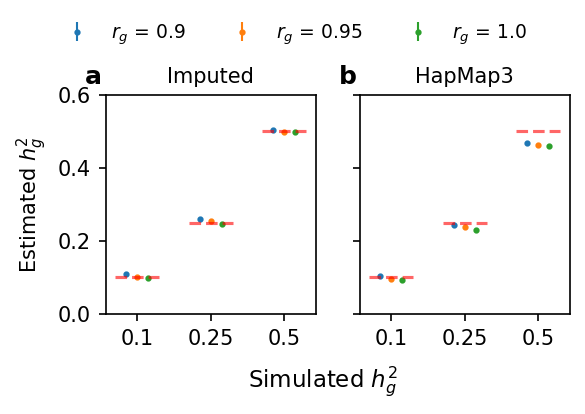

In [31]:
dict_title = {"hm3": "HapMap3", "imputed": "Imputed"}

fig, axes = plt.subplots(figsize=(4.0, 2.2), dpi=150, ncols=2, sharey=True)
for i_snpset, snpset in enumerate(["imputed", "hm3"]):

    # error bars
    for i_cor, cor in enumerate([0.9, 0.95, 1.0]):
        df_tmp = df_plot[(df_plot.snpset == snpset) & (df_plot.cor == cor)]

        axes[i_snpset].errorbar(
            x=np.arange(len(df_tmp)) + (i_cor - 1) * 0.15,
            y=df_tmp["mean"],
            yerr=df_tmp["sem"] * 2,
            fmt=".",
            ms=4,
            mew=1,
            lw=1,
            label=f"$r_g$ = {cor}",
        )

    # box plots
    # x-axis
    axes[i_snpset].set_xticks([0, 1, 2])
    axes[i_snpset].set_xticklabels([0.1, 0.25, 0.5])

    # y-axis
    axes[i_snpset].set_ylim(0, 0.6)
    if i_snpset == 0:
        axes[i_snpset].set_ylabel("Estimated $h_g^2$")

    # title
    axes[i_snpset].set_title(dict_title[snpset], fontsize=10)
    for i_hsq, hsq in enumerate([0.1, 0.25, 0.5]):
        axes[i_snpset].hlines(
            y=hsq,
            xmin=i_hsq - 0.3,
            xmax=i_hsq + 0.3,
            color="red",
            ls="--",
            alpha=0.6,
            zorder=10,
        )
    # annotation
    axes[i_snpset].text(
        -0.1,
        1.05,
        string.ascii_lowercase[i_snpset],
        transform=axes[i_snpset].transAxes,
        size=12,
        weight="bold",
    )

fig.text(
    0.55,
    -0.05,
    "Simulated $h_g^2$",
    fontsize=11,
    ha="center",
)

handles, labels = axes[0].get_legend_handles_labels()
# handles = ph + handles
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.tight_layout()
fig.savefig("results/estimate-h2g.pdf", bbox_inches="tight")